In [7]:
import pandas as pd
import seaborn as sns 
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.feature_selection import SelectFromModel
%matplotlib inline
import csv

# Self-trained Model

In [15]:
data = pd.read_csv('train_with_label.csv')

In [16]:
data.head()

,Unnamed: 0,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Technology,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Technology,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Technology,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Technology,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Technology,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


For a typlical classification task, we could use multiple features of this dataset to actually classify the industry of a person based on a description. However, we only have access to description and title in our curated dataset amongst other features that do not overlap with this datasset. We thus choose only these two columns as features for our classification task and treat category as our outcome or label that we try to classify. 

In [17]:
data.shape

(244768, 13)

In [18]:
final_data = data[['Category', 'Title', 'FullDescription']]
final_data.groupby(by = 'Category').count()

,Title,FullDescription
Category,,
Business/Finance,70494,70494
Charity/Volunteering,2332,2332
Consulting,3263,3263
Education/Research,15126,15126
Healthcare,21075,21076
Human Resources,7713,7713
Law,3939,3939
Others,53713,53713
Policy/Government/Social Work,3455,3455


We can see that while Business/Finance have the most number of entries, and Charity/Volunteering has few. In order to ensure that we have a fairly equal distribution of classes and this imbalance does not affect our final task at hand, we take the class with the least number of entries (2332) and downsample the other classes to get this number. While we would lose a lot of data in doing so, it also ensures that we don't end up with a biased model for our downstream task. We can always reweigh these classes to ensure better usage of data.

In [19]:
final_data = pd.concat([final_data[final_data['Category']=='Business/Finance'].sample(n=2238),
                        final_data[final_data['Category']=='Charity/Volunteering'].sample(n=2238),
                final_data[final_data['Category']== 'Consulting'].sample(n=2238), 
                final_data[final_data['Category']=='Education/Research'].sample(n=2238),
                final_data[final_data['Category']=='Healthcare'].sample(n=2238),
                final_data[final_data['Category']=='Human Resources'].sample(n=2238),
                final_data[final_data['Category']=='Law'].sample(n=2238),
                final_data[final_data['Category']=='Others'].sample(n=2238),
                final_data[final_data['Category']=='Policy/Government/Social Work'].sample(n=2238),
                final_data[final_data['Category']=='Technology'].sample(n=2238)]
                )

In [20]:
final_data.groupby(by = 'Category').count()

,Title,FullDescription
Category,,
Business/Finance,2238,2238
Charity/Volunteering,2238,2238
Consulting,2238,2238
Education/Research,2238,2238
Healthcare,2238,2238
Human Resources,2238,2238
Law,2238,2238
Others,2238,2238
Policy/Government/Social Work,2238,2238


In [21]:
final_data['length'] = final_data['FullDescription'].apply(len)

<Figure size 14760x1440 with 0 Axes>

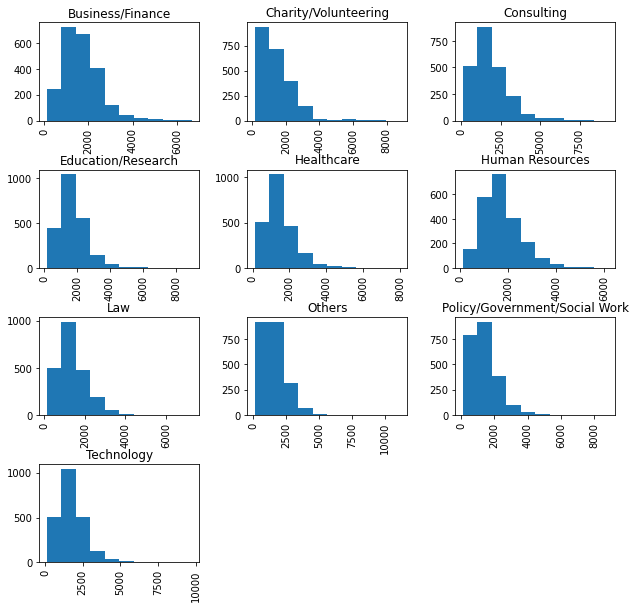

In [22]:

plt.figure(figsize=(205 ,20))
final_data.hist(column='length', by='Category',figsize=(10,10))
plt.show()

In [23]:
final_data.isna().sum()

Category           0
Title              0
FullDescription    0
length             0
dtype: int64

We have no missing values! Let's take a look at what a description actually looks like!

In [24]:
pd.set_option('display.max_colwidth', -1)
final_data['FullDescription'].head(1)

<ipython-input-24-ecdd4f5946b6>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


96658    Planning Manager North West Financial Services **** month FTC Competitive salary My client is a major financial services provider that has an urgent requirement for a Planning Manager to join their North West site on an initial **** month fixed term contract. This role can offer the right individual a fantastic opportunity to further their career within an organisation that continues to strive for excellence by being the number one in their field. As a Planning Manager, you will be responsible for leading the end to end resource planning, enabling the correct resource allocation. You will be required to provide ongoing budget information and assist in the operational areas of the business. The role will suit a Planning Manager who has proved themselves in this field, but is now looking for the next step and an opportunity that will challenge them from the word go. As a Planning Manager, you will require the following experience: Proven experience as a Planning Manager Forecast

Clearly, this needs to be preprocessed

In [25]:
def clean_text(row):
    
    row = re.sub(r"n\'t", " not", row)
    row = re.sub(r"n\'ll", " will", row)
    row = re.sub(r"n\'ve", " have", row)
    row = re.sub(r"n\'t", " not", row)
    row = re.sub(r"i.e", " ", row)
    row = re.sub(r"n\'s", "", row)
    row = re.sub("[^a-zA-Z]"," ", row)
    white_space = re.compile(r"\s+")
    row = white_space.sub(" ", row).strip()
    return row 

In [26]:
final_data['FullDescription'] = (final_data['FullDescription']).apply(lambda row: clean_text(row))

In [27]:
final_data['FullDescription'].tail(1)

94451    Software Development Manager Java Music Film TV Industry London Location London near Euston and King s Cross PLEASE NOTE THIS IS NOT A SOFTWARE DEVELOPMENT ROLE THE COMPANY This software house is the world leader in the provision of software systems to the music and entertainment industry They are looking for a former Java software developer with some experience of managing software development teams who now perhaps would l to move away from coding into management You would join their expanding London off and manage their Java software development team Company s is just under staff and growing and they are the market leaders of their niche The working environment here is very pleasant with a casual dress code laid back and friendly atmosphere but also hardworking and dynamic with the autonomy to dr your job role forward EXPERIENCE REQUIRED A minimum of years previous experience in Java J EE handson software development with experience of both front and Back End development Pre

## Feature representation
We now move to feature representation of the title and description

In [28]:
final_data.reset_index(inplace = True)

Since we would like to use both description and title, we concatenate them into one column and then vectorize this column to that we can convert the text to numbers that the model can understand.

In [29]:
final_data["concat_text"] = final_data.FullDescription.astype(str) + final_data.Title.astype(str)

In [30]:
stopwords = set(['i','l','my','it','off','means','if','you','husband','do','what','and','a','an'
             'is','for','this','after','the','so','to','m', 'that','into','those','were','was',
             'other','some','are','now','ry','at','serv','t','s','rece',
             'in','don','adv','word','let','her','him','he','she','them','they','be','been',
             've','some', 'such','qu','same','only','up','here','there','do','very','over',
             'but','via','felt','who','whom','whose','where','how','about','just','most','has',
             'had','have','way','back','front','let','flow','sun','del','your','move','got','air',
              'breath', 'dude','know','mean','pan','means','mine','both','with','another','bit',
              'clumps','needs','room','code','one','ones','f', 'em','as','n','cho','me','descr',
              'pr','compet','re','could','would','should','even','r','out','their','n','ly','down',
              'from','because','until','unless','while','its','about','all','any','few','too',
              'own','itself','ppl','keep','really','got','AP','close'])

vect = TfidfVectorizer(lowercase = True, stop_words = {'english'}.update(stopwords), max_df = .8, min_df = 3) 
X = vect.fit_transform(final_data.concat_text)

y = final_data.Category

In [31]:
print(X.shape,y.shape)

(22380, 18999) (22380,)


## Logistic Regression

In [48]:
lg = LogisticRegression(max_iter = 1000) 

## Added grid search

In [54]:
grid = {"C":np.logspace(-3,3,7), "penalty":["l2"]}# l2 ridge
lg_cv = GridSearchCV(lg,grid,cv=10)

In [55]:
lg_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [1], 'penalty': ['l2']})

In [56]:
print("tuned hpyerparameters :(best parameters) ",lg_cv.best_params_)
print("accuracy :",lg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1, 'penalty': 'l2'}
accuracy : 0.7082955946437507


In [57]:
lg = LogisticRegression(C=1,penalty="l2")
selector = SelectFromModel(lg, max_features=4113)
X_train_selected = selector.fit_transform(X, y)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Splitting data into train and test set

In [59]:
print(np.arange(final_data.shape[0]))
train_idx, test_idx = train_test_split(np.arange(final_data.shape[0]), test_size=0.4, 
                                       shuffle=True, random_state=42)
X_train = X_train_selected[train_idx]
Y_train = y[train_idx]
X_test = X_train_selected[test_idx]
Y_test = y[test_idx]

[    0     1     2 ... 22377 22378 22379]


In [60]:
lg.fit(X_train, Y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1)

In [61]:
y_pred = lg.predict(X_test)

## Looking at the performance!

In [62]:
print(classification_report(Y_test, y_pred))

                               precision    recall  f1-score   support

             Business/Finance       0.53      0.65      0.58       866
         Charity/Volunteering       0.75      0.76      0.76       920
                   Consulting       0.51      0.46      0.48       907
           Education/Research       0.77      0.76      0.77       923
                   Healthcare       0.76      0.73      0.74       905
              Human Resources       0.79      0.76      0.77       866
                          Law       0.95      0.92      0.94       902
                       Others       0.60      0.51      0.55       908
Policy/Government/Social Work       0.72      0.72      0.72       866
                   Technology       0.69      0.77      0.73       889

                     accuracy                           0.71      8952
                    macro avg       0.71      0.71      0.70      8952
                 weighted avg       0.71      0.71      0.70      8952



## Naive Bayes

In [63]:
vect = TfidfVectorizer(stop_words= {'english'}.update(stopwords))
nb = MultinomialNB() 
vect = TfidfVectorizer(lowercase = True, stop_words = {'english'}.update(stopwords), max_df = .7, min_df = 5) 
X = vect.fit_transform(final_data.concat_text)
y = final_data.Category

In [64]:
train_idx, test_idx = train_test_split(np.arange(final_data.shape[0]), test_size=0.4, 
                                       shuffle=True, random_state=42)
X_train = X[train_idx]
Y_train = y[train_idx]
X_test = X[test_idx]
Y_test = y[test_idx]

In [65]:
clf = MultinomialNB(alpha = 1)
clf.fit(X_train, Y_train)

MultinomialNB(alpha=1)

In [66]:
y_pred = clf.predict(X_test)

In [67]:
print(classification_report(Y_test, y_pred))

                               precision    recall  f1-score   support

             Business/Finance       0.49      0.70      0.57       866
         Charity/Volunteering       0.77      0.69      0.73       920
                   Consulting       0.48      0.39      0.43       907
           Education/Research       0.79      0.72      0.75       923
                   Healthcare       0.73      0.72      0.72       905
              Human Resources       0.67      0.80      0.73       866
                          Law       0.94      0.90      0.92       902
                       Others       0.71      0.41      0.52       908
Policy/Government/Social Work       0.65      0.72      0.68       866
                   Technology       0.67      0.79      0.72       889

                     accuracy                           0.68      8952
                    macro avg       0.69      0.68      0.68      8952
                 weighted avg       0.69      0.68      0.68      8952



In [75]:
small_data = pd.read_csv('work_exp_with_label.csv')

In [76]:
small_data = small_data[['description', 'company', 'position', 'industry']]

In [77]:
small_data.dropna(inplace = True)

In [78]:

small_data.groupby(by = 'industry').count()

,description,company,position
industry,,,
Business/Finance,256,256,256
Charity/Volunteering,119,119,119
Consulting,36,36,36
Education/Research,398,398,398
Healthcare,51,51,51
Human Resources,46,46,46
Law,116,116,116
Others,688,688,688
Policy/Government/Social Work,99,99,99


In [79]:
small_data['description'] = (small_data['description']).apply(lambda row: clean_text(row))

In [81]:
small_data["concat_text"] = small_data.description.astype(str) + small_data.position.astype(str)

In [82]:
vect = TfidfVectorizer(lowercase = True, stop_words = {'english'}.update(stopwords), max_df = .5, min_df = 2) 
X = vect.fit_transform(small_data.concat_text)
y = small_data.industry

In [84]:
y_pred = lg.predict(X)

In [85]:
print(classification_report(y, y_pred))

                               precision    recall  f1-score   support

             Business/Finance       0.12      0.04      0.05       256
         Charity/Volunteering       0.05      0.18      0.08       119
                   Consulting       0.04      0.08      0.06        36
           Education/Research       0.25      0.13      0.17       398
                   Healthcare       0.03      0.02      0.02        51
              Human Resources       0.00      0.00      0.00        46
                          Law       0.03      0.01      0.01       116
                       Others       0.35      0.50      0.41       688
Policy/Government/Social Work       0.03      0.01      0.02        99
                   Technology       0.11      0.10      0.11       238

                     accuracy                           0.22      2047
                    macro avg       0.10      0.11      0.09      2047
                 weighted avg       0.20      0.22      0.20      2047



# DistilBert Model

In [89]:
!pip install transformers
!pip install nlu
!pip install pyspark==3.0.2
!pip install Counter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 49.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 KB 13.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 KB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.6/532.6 KB 31.3 MB/s eta 0:00:00


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.8/204.8 MB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 KB 17.7 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.0.2-py2.py3-none-any.whl size=205186690 sha256=38fae43493d711bbd9b4674d9d4fe4d6e001c504d9944c77529d7cbb01e53005
  Stored in directory: /root/.cache/pip/wheels/aa/8e/b9/ed8017fb2997a648f5868a4b728881f320e3d1bd2b0274f137
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for Counter: filename=Counter-1.0.0-py3-none-any.whl size=5411 sha256=8d665809eb53ce38ea9eb485a9de2156937169abba8c08984a9f8a4b26392811
  Stored in directory: /root/.cache/pip/wheels/8c/53/bd/a2a81742d0585769e6f7304ccafdd9d85b828371602b103728
Succes

In [90]:
import nlu
nlu_model = nlu.load("en.classify.distilbert_sequence.industry")
from collections import Counter
def most_common(lst):
    data = Counter(lst)
    return max(lst, key=data.get)

distilbert_sequence_classifier_industry download started this may take some time.
Approximate size to download 238.4 MB
[OK!]


In [92]:
industry_true = small_data[['industry']]

In [93]:
industry = []

In [95]:
for i, row in enumerate(small_data['description']):
  if type(row) == str:
    if type(nlu_model.predict(row)['classified_sequence'][0]) == str:
      lst = []
      ind_pred = nlu_model.predict(row)['classified_sequence']
      for val in ind_pred:
        lst.append(val)
      industry.append(most_common(lst))
    else:
      industry.append('Others')

sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]


In [97]:
id2label = {'0': 'Advertising',
 '1': 'Aerospace & Defense',
 '2': 'Apparel Retail',
 '3': 'Apparel, Accessories & Luxury Goods',
 '4': 'Application Software',
 '5': 'Asset Management & Custody Banks',
 '6': 'Auto Parts & Equipment',
 '7': 'Biotechnology',
 '8': 'Building Products',
 '9': 'Casinos & Gaming',
 '10': 'Commodity Chemicals',
 '11': 'Communications Equipment',
 '12': 'Construction & Engineering',
 '13': 'Construction Machinery & Heavy Trucks',
 '14': 'Consumer Finance',
 '15': 'Data Processing & Outsourced Services',
 '16': 'Diversified Metals & Mining',
 '17': 'Diversified Support Services',
 '18': 'Electric Utilities',
 '19': 'Electrical Components & Equipment',
 '20': 'Electronic Equipment & Instruments',
 '21': 'Environmental & Facilities Services',
 '22': 'Gold',
 '23': 'Health Care Equipment',
 '24': 'Health Care Facilities',
 '25': 'Health Care Services',
 '26': 'Health Care Supplies',
 '27': 'Health Care Technology',
 '28': 'Homebuilding',
 '29': 'Hotels, Resorts & Cruise Lines',
 '30': 'Human Resource & Employment Services',
 '31': 'IT Consulting & Other Services',
 '32': 'Industrial Machinery',
 '33': 'Integrated Telecommunication Services',
 '34': 'Interactive Media & Services',
 '35': 'Internet & Direct Marketing Retail',
 '36': 'Internet Services & Infrastructure',
 '37': 'Investment Banking & Brokerage',
 '38': 'Leisure Products',
 '39': 'Life Sciences Tools & Services',
 '40': 'Movies & Entertainment',
 '41': 'Oil & Gas Equipment & Services',
 '42': 'Oil & Gas Exploration & Production',
 '43': 'Oil & Gas Refining & Marketing',
 '44': 'Oil & Gas Storage & Transportation',
 '45': 'Packaged Foods & Meats',
 '46': 'Personal Products',
 '47': 'Pharmaceuticals',
 '48': 'Property & Casualty Insurance',
 '49': 'Real Estate Operating Companies',
 '50': 'Regional Banks',
 '51': 'Research & Consulting Services',
 '52': 'Restaurants',
 '53': 'Semiconductors',
 '54': 'Specialty Chemicals',
 '55': 'Specialty Stores',
 '56': 'Steel',
 '57': 'Systems Software',
 '58': 'Technology Distributors',
 '59': 'Technology Hardware, Storage & Peripherals',
 '60': 'Thrifts & Mortgage Finance',
 '61': 'Trading Companies & Distributors'}

In [98]:
for i, ind in enumerate(industry):
    if id2label['4']  in ind or id2label['15']  in ind or id2label['18']  in ind or id2label['19']  in ind or id2label['20']  in ind or id2label['57']  in ind or id2label['58']  in ind or id2label['59']  in ind or id2label['33'] in ind:
        industry[i] = 'Technology'
    elif id2label['30'] in ind:
        industry[i] = 'Human Resources'
    elif id2label['0']  in ind or id2label['2']  in ind or id2label['3']  in ind or id2label['5']  in ind or id2label['8']  in ind or id2label['9']  in ind or id2label['14']  in ind or id2label['29']  in ind or id2label['34']  in ind or id2label['35']  in ind or id2label['36']  in ind or id2label['37']  in ind or id2label['38']  in ind or id2label['40']  in ind or id2label['46']  in ind or id2label['49']  in ind or id2label['50']  in ind or id2label['52']  in ind or id2label['55']  in ind or id2label['60']  in ind or id2label['61'] in ind:
        industry[i] = 'Business/Finance'
    elif id2label['7']  in ind or id2label['23']  in ind or id2label['24']  in ind or id2label['25']  in ind or id2label['26']  in ind or id2label['27']  in ind or id2label['39']  in ind or id2label['47'] in ind:
        industry[i] = 'Healthcare'
    elif id2label['51'] in ind:
        industry[i] = 'Education/Research'
    elif id2label['31'] in ind:
        industry[i] = 'Consulting'
    elif id2label['14']  in ind or id2label['48'] in ind:
        industry[i] = 'Education/Research'
    elif id2label['17'] in ind:
        industry[i] = 'Charity/Volunteering'
    elif id2label['1']  in ind or id2label['21']  in ind or id2label['32'] in ind:
        industry[i] = 'Policy/Government/Social Work'
    else:
        industry[i] = 'Others' 

In [99]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(industry_true, industry))

                               precision    recall  f1-score   support

             Business/Finance       0.20      0.32      0.25       256
         Charity/Volunteering       0.14      0.18      0.16       119
                   Consulting       0.00      0.00      0.00        36
           Education/Research       0.20      0.26      0.23       398
                   Healthcare       0.09      0.65      0.16        51
              Human Resources       0.10      0.41      0.15        46
                          Law       0.00      0.00      0.00       116
                       Others       0.51      0.04      0.07       688
Policy/Government/Social Work       0.04      0.01      0.02        99
                   Technology       0.26      0.32      0.29       238

                     accuracy                           0.18      2047
                    macro avg       0.15      0.22      0.13      2047
                 weighted avg       0.28      0.18      0.15      2047

